In [185]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
from datetime import datetime, date, timedelta

import yfinance as yfin
yfin.pdr_override()

import matplotlib.pyplot as plt
import seaborn as sns

#from var import VaR

pd.set_option('display.float_format', lambda x: f'{x:,.6f}')

# Assignment
Familiarity with several pricing models and how to apply them to a portfolio. Now calculate the VWAP, Sharpe and Alpha for your portfolio from the start of the semester  to the date of you calculations. Your calculation results and the VaR calculations that you performed last week are the main content of the Portfolio Review presentation that is next week's subject and assignment. -- Remember Presentation is Important

# Variables

In [186]:
start_date = datetime(2022, 1, 1)
end_date = datetime.now()
alpha = 0.05
period = '5y'

# Functions

# Load Data

## Load Variables

In [187]:
var_lst = ['^TNX']
data = pdr.get_data_yahoo(var_lst, period=period)['Close']
rf_df = data.pct_change()
#rf_rate = round((data.mean() / 100),4)
#rf_rate
rf_rate = rf_df.mean()
rf_rate

[*********************100%%**********************]  1 of 1 completed


0.0010885207894323365

## Load Portfolio

In [188]:
folio_df = pd.read_csv('https://raw.githubusercontent.com/dsimband/DATA618/main/w6/data/DATA618_Portfolio.csv', 
                 dtype={
                    'ID': 'int',
                    'Price': 'float',
                    'Shares': 'float',
                    'Value': 'float', 
                 })


folio_df = folio_df[folio_df['Shares'] > 0]
folio_df = folio_df.groupby(['Ticker','BondName','Class'])[['Shares','Value']].sum()
folio_df.reset_index(inplace=True)
#folio_df['Morningstar_Category'].fillna('Other', inplace=True)

#folio_df = folio_df[4:]

portfolio_total = folio_df['Value'].sum()
folio_df['port_percent'] = folio_df['Value'] / portfolio_total

folio_df.head()

,Ticker,BondName,Class,Shares,Value,port_percent
0,ALTVX,AB Municipal Income National Advisor,Interest Rate Sensitive,"106,383.000000","1,000.000000",0.011945
1,BLUEX,AMG Veritas Global Real Return I,Economically Sensitive,"14,201.000000",500.000000,0.005972
2,BPLSX,Boston Partners Long/Short Equity Instl,Economically Sensitive,"49,967.000000",750.000000,0.008959
3,C_A_S_H,Cash,Cash,"4,469,000.000000","4,469.000000",0.053381
4,DFAR,Dimensional US Real Estate ETF,Economically Sensitive,"108,467.000000","2,250.000000",0.026876


In [189]:
folio_df.groupby(['Class'])[['Value']].sum()

,Value
Class,
Cash,"4,469.000000"
Economically Sensitive,"50,250.000000"
Interest Rate Sensitive,"29,000.000000"


In [190]:
initial_investment = folio_df['Value'].sum() * 1000
initial_investment

83719000.0

## Load Pricing Time Series

In [191]:
# ticker symbols
ticker_lst = list(folio_df['Ticker'])
print('ticker #:', len(ticker_lst))


# portfolio weights
weight_lst = (folio_df['port_percent'].values)
print('price #:', len(weight_lst))


#Download closing prices
#price_df = pdr.get_data_yahoo(ticker_lst, start=start_date, end=end_date)['Close']
price_df = pdr.get_data_yahoo(ticker_lst, period=period)['Close']

price_df['C_A_S_H'] = 1
print('price_df #:', len(price_df.columns))

#From the closing prices, calculate periodic returns
return_df = price_df.pct_change()
print('return_df #:', len(return_df.columns))

ticker #: 35
price #: 35
[*********************100%%**********************]  35 of 35 completed


1 Failed download:
['C_A_S_H']: Exception('%ticker%: No data found, symbol may be delisted')



price_df #: 35
return_df #: 35


In [192]:
print('ticker #:', len(ticker_lst))

ticker #: 35


In [193]:
price_df

,ALTVX,BLUEX,BPLSX,C_A_S_H,DFAR,FREL,FSMD,GARIX,GCHDX,ICBFX,...,SWRSX,VBR,VFIUX,VGCAX,VICSX,VIGI,VNQ,VO,VONG,VTEB
Date,,,,,,,,,,,,,,,,,,,,,
2018-10-08,9.980000,53.700001,21.040001,1,NaN,23.670000,NaN,14.810000,12.560000,6.970000,...,10.680000,136.429993,10.610000,NaN,22.260000,61.770000,79.330002,160.139999,38.782501,50.110001
2018-10-09,9.960000,53.770000,21.070000,1,NaN,23.750000,NaN,14.770000,12.550000,6.970000,...,10.690000,135.649994,10.620000,NaN,22.270000,61.555000,79.440002,159.460007,38.775002,50.119999
2018-10-10,9.940000,51.230000,20.809999,1,NaN,23.379999,NaN,14.580000,12.310000,6.960000,...,10.670000,132.470001,10.630000,NaN,22.280001,59.730000,78.260002,154.490005,37.230000,50.029999
2018-10-11,9.950000,50.720001,20.520000,1,NaN,22.719999,NaN,14.380000,12.150000,6.980000,...,10.700000,129.600006,10.650000,NaN,22.320000,59.459999,76.019997,151.399994,36.625000,50.090000
2018-10-12,9.950000,52.119999,20.549999,1,NaN,22.660000,NaN,14.490000,12.270000,6.970000,...,10.700000,129.300003,10.640000,NaN,22.290001,60.099998,75.820000,152.940002,37.439999,50.020000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-02,9.140000,33.840000,14.780000,1,19.180000,22.330000,31.882000,19.469999,10.540000,5.840000,...,9.820000,156.940002,9.540000,17.860001,20.280001,70.550003,74.269997,205.800003,69.029999,47.709999
2023-10-03,9.110000,33.630001,14.700000,1,18.809999,21.889999,31.458000,19.290001,10.450000,5.790000,...,9.760000,154.460007,9.490000,17.740000,20.110001,69.879997,72.820000,202.940002,67.800003,47.570000
2023-10-04,9.110000,33.820000,14.690000,1,19.030001,22.129999,31.680000,19.400000,10.530000,5.820000,...,9.800000,155.059998,9.530000,17.820000,20.219999,70.379997,73.709999,204.550003,68.690002,47.730000


In [194]:
return_df = return_df[1:]
return_df

,ALTVX,BLUEX,BPLSX,C_A_S_H,DFAR,FREL,FSMD,GARIX,GCHDX,ICBFX,...,SWRSX,VBR,VFIUX,VGCAX,VICSX,VIGI,VNQ,VO,VONG,VTEB
Date,,,,,,,,,,,,,,,,,,,,,
2018-10-09,-0.002004,0.001304,0.001426,0.000000,NaN,0.003380,NaN,-0.002701,-0.000796,0.000000,...,0.000936,-0.005717,0.000943,NaN,0.000449,-0.003481,0.001387,-0.004246,-0.000193,0.000200
2018-10-10,-0.002008,-0.047238,-0.012340,0.000000,NaN,-0.015579,NaN,-0.012864,-0.019123,-0.001435,...,-0.001871,-0.023443,0.000942,NaN,0.000449,-0.029648,-0.014854,-0.031168,-0.039845,-0.001796
2018-10-11,0.001006,-0.009955,-0.013936,0.000000,NaN,-0.028229,NaN,-0.013717,-0.012998,0.002874,...,0.002812,-0.021665,0.001881,NaN,0.001795,-0.004520,-0.028623,-0.020001,-0.016250,0.001199
2018-10-12,0.000000,0.027602,0.001462,0.000000,NaN,-0.002641,NaN,0.007649,0.009877,-0.001433,...,0.000000,-0.002315,-0.000939,NaN,-0.001344,0.010764,-0.002631,0.010172,0.022253,-0.001397
2018-10-15,0.000000,-0.008826,-0.000487,0.000000,NaN,0.005737,NaN,-0.002070,-0.004075,0.000000,...,-0.000935,0.005414,0.000940,NaN,0.001346,-0.005324,0.006726,0.001177,-0.007879,-0.000400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-02,-0.003272,-0.004413,-0.002699,0.000000,-0.017418,-0.018462,-0.012024,0.000000,-0.001894,-0.008489,...,-0.007078,-0.015988,-0.005214,-0.005014,-0.007828,-0.010935,-0.018372,-0.011717,0.008621,-0.008108
2023-10-03,-0.003282,-0.006206,-0.005413,0.000000,-0.019291,-0.019704,-0.013299,-0.009245,-0.008539,-0.008562,...,-0.006110,-0.015802,-0.005241,-0.006719,-0.008383,-0.009497,-0.019523,-0.013897,-0.017818,-0.002934
2023-10-04,0.000000,0.005650,-0.000680,0.000000,0.011696,0.010964,0.007057,0.005702,0.007655,0.005181,...,0.004098,0.003884,0.004215,0.004510,0.005470,0.007155,0.012222,0.007933,0.013127,0.003363


## Analytics

return_df.corr()

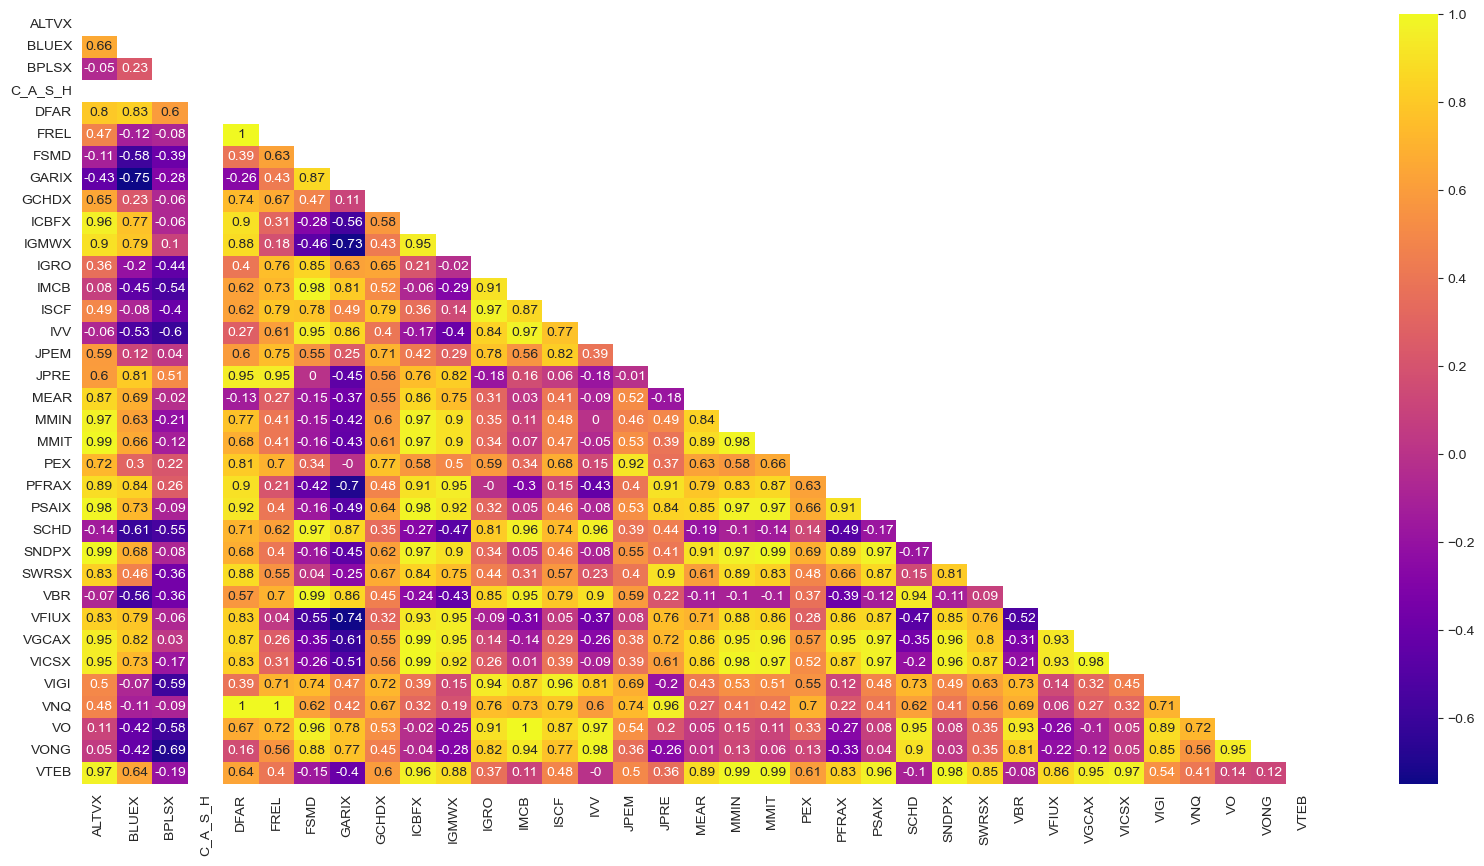

In [195]:
plt.figure(figsize=(20,10))
mask = np.zeros_like(price_df.corr())
mask[np.triu_indices_from(mask)] = True
sns.set_style("white")
_p = sns.heatmap(price_df.corr().round(2), 
                 annot=True, mask=mask, 
                 cmap="plasma", annot_kws={"size": 10})

# VaR Calculation

#Generate Var-Cov matrix
cov_matrix = return_df.cov()
cov_matrix

#Calculate mean returns for each stock
avg_ret_df = return_df.mean()

#Calculate mean returns for portfolio overall,
#using mean, using dot product formula to
#normalize against investment weights
port_mean = avg_ret_df.dot(weight_lst)

#Calculate portfolio standard deviation
port_stdev = np.sqrt(weight_lst.T.dot(cov_matrix).dot(weight_lst))

#Calculate mean of given investment
mean_investment = (1+port_mean) * initial_investment

#Calculate standard deviation of given investmnet
stdev_investment = initial_investment * port_stdev

## Calculate the inverse of the normal cumulative distribution (PPF)

#Using SciPy ppf method to generate values for the inverse cumulative distribution function to a normal distribution
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html
from scipy.stats import norm
cutoff1 = norm.ppf(alpha, mean_investment, stdev_investment)

#Finally, we can calculate the VaR at our confidence interval
var_1d1 = initial_investment - cutoff1
var_1d1

## Value at risk over n-day time period

# Calculate n Day VaR
var_array = []
num_days = int(30)
for x in range(1, num_days+1):
    var_array.append(np.round(var_1d1 * np.sqrt(x),2))
    print(str(x) + " day VaR @ 95% confidence: " + str(np.round(var_1d1 * np.sqrt(x),2)))

# Build plot
plt.xlabel("Day #")
plt.ylabel("Max portfolio loss (USD)")
plt.title("Max portfolio loss (VaR) over 15-day period")
plt.plot(var_array, "r")

# Sharpe Calculation 

In [196]:
port_ret_weighted= return_df.mul(weight_lst, axis=1)
port_ret_weighted

,ALTVX,BLUEX,BPLSX,C_A_S_H,DFAR,FREL,FSMD,GARIX,GCHDX,ICBFX,...,SWRSX,VBR,VFIUX,VGCAX,VICSX,VIGI,VNQ,VO,VONG,VTEB
Date,,,,,,,,,,,,,,,,,,,,,
2018-10-09,-0.000024,0.000008,0.000013,0.000000,NaN,0.000113,NaN,-0.000016,-0.000005,0.000000,...,0.000067,-0.000068,0.000062,NaN,0.000011,-0.000125,0.000054,-0.000101,-0.000007,0.000002
2018-10-10,-0.000024,-0.000282,-0.000111,0.000000,NaN,-0.000521,NaN,-0.000077,-0.000114,-0.000017,...,-0.000134,-0.000280,0.000062,NaN,0.000011,-0.001062,-0.000577,-0.000745,-0.001428,-0.000021
2018-10-11,0.000012,-0.000059,-0.000125,0.000000,NaN,-0.000944,NaN,-0.000082,-0.000078,0.000034,...,0.000202,-0.000259,0.000124,NaN,0.000043,-0.000162,-0.001111,-0.000478,-0.000582,0.000014
2018-10-12,0.000000,0.000165,0.000013,0.000000,NaN,-0.000088,NaN,0.000046,0.000059,-0.000017,...,0.000000,-0.000028,-0.000062,NaN,-0.000032,0.000386,-0.000102,0.000243,0.000797,-0.000017
2018-10-15,0.000000,-0.000053,-0.000004,0.000000,NaN,0.000192,NaN,-0.000012,-0.000024,0.000000,...,-0.000067,0.000065,0.000062,NaN,0.000032,-0.000191,0.000261,0.000028,-0.000282,-0.000005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-02,-0.000039,-0.000026,-0.000024,0.000000,-0.000468,-0.000617,-0.000574,0.000000,-0.000011,-0.000101,...,-0.000507,-0.000191,-0.000343,-0.000060,-0.000187,-0.000392,-0.000713,-0.000280,0.000309,-0.000097
2023-10-03,-0.000039,-0.000037,-0.000048,0.000000,-0.000518,-0.000659,-0.000635,-0.000055,-0.000051,-0.000102,...,-0.000438,-0.000189,-0.000344,-0.000080,-0.000200,-0.000340,-0.000758,-0.000332,-0.000639,-0.000035
2023-10-04,0.000000,0.000034,-0.000006,0.000000,0.000314,0.000367,0.000337,0.000034,0.000046,0.000062,...,0.000294,0.000046,0.000277,0.000054,0.000131,0.000256,0.000474,0.000190,0.000470,0.000040


In [197]:
return_df['Portfolio']= port_ret_weighted.sum(axis=1).dropna()
return_df

,ALTVX,BLUEX,BPLSX,C_A_S_H,DFAR,FREL,FSMD,GARIX,GCHDX,ICBFX,...,VBR,VFIUX,VGCAX,VICSX,VIGI,VNQ,VO,VONG,VTEB,Portfolio
Date,,,,,,,,,,,,,,,,,,,,,
2018-10-09,-0.002004,0.001304,0.001426,0.000000,NaN,0.003380,NaN,-0.002701,-0.000796,0.000000,...,-0.005717,0.000943,NaN,0.000449,-0.003481,0.001387,-0.004246,-0.000193,0.000200,-0.000577
2018-10-10,-0.002008,-0.047238,-0.012340,0.000000,NaN,-0.015579,NaN,-0.012864,-0.019123,-0.001435,...,-0.023443,0.000942,NaN,0.000449,-0.029648,-0.014854,-0.031168,-0.039845,-0.001796,-0.011822
2018-10-11,0.001006,-0.009955,-0.013936,0.000000,NaN,-0.028229,NaN,-0.013717,-0.012998,0.002874,...,-0.021665,0.001881,NaN,0.001795,-0.004520,-0.028623,-0.020001,-0.016250,0.001199,-0.008377
2018-10-12,0.000000,0.027602,0.001462,0.000000,NaN,-0.002641,NaN,0.007649,0.009877,-0.001433,...,-0.002315,-0.000939,NaN,-0.001344,0.010764,-0.002631,0.010172,0.022253,-0.001397,0.003451
2018-10-15,0.000000,-0.008826,-0.000487,0.000000,NaN,0.005737,NaN,-0.002070,-0.004075,0.000000,...,0.005414,0.000940,NaN,0.001346,-0.005324,0.006726,0.001177,-0.007879,-0.000400,-0.000588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-02,-0.003272,-0.004413,-0.002699,0.000000,-0.017418,-0.018462,-0.012024,0.000000,-0.001894,-0.008489,...,-0.015988,-0.005214,-0.005014,-0.007828,-0.010935,-0.018372,-0.011717,0.008621,-0.008108,-0.008877
2023-10-03,-0.003282,-0.006206,-0.005413,0.000000,-0.019291,-0.019704,-0.013299,-0.009245,-0.008539,-0.008562,...,-0.015802,-0.005241,-0.006719,-0.008383,-0.009497,-0.019523,-0.013897,-0.017818,-0.002934,-0.010736
2023-10-04,0.000000,0.005650,-0.000680,0.000000,0.011696,0.010964,0.007057,0.005702,0.007655,0.005181,...,0.003884,0.004215,0.004510,0.005470,0.007155,0.012222,0.007933,0.013127,0.003363,0.004713


In [198]:
tickers='^DJA'
DJA = pdr.get_data_yahoo(tickers=tickers, period=period)
return_df['Benchmark']= DJA['Close']
return_df['Benchmark']= return_df['Benchmark'].pct_change(1) #.dropna()
#return_df= return_df.dropna()
return_df

[*********************100%%**********************]  1 of 1 completed


,ALTVX,BLUEX,BPLSX,C_A_S_H,DFAR,FREL,FSMD,GARIX,GCHDX,ICBFX,...,VFIUX,VGCAX,VICSX,VIGI,VNQ,VO,VONG,VTEB,Portfolio,Benchmark
Date,,,,,,,,,,,,,,,,,,,,,
2018-10-09,-0.002004,0.001304,0.001426,0.000000,NaN,0.003380,NaN,-0.002701,-0.000796,0.000000,...,0.000943,NaN,0.000449,-0.003481,0.001387,-0.004246,-0.000193,0.000200,-0.000577,NaN
2018-10-10,-0.002008,-0.047238,-0.012340,0.000000,NaN,-0.015579,NaN,-0.012864,-0.019123,-0.001435,...,0.000942,NaN,0.000449,-0.029648,-0.014854,-0.031168,-0.039845,-0.001796,-0.011822,-0.030125
2018-10-11,0.001006,-0.009955,-0.013936,0.000000,NaN,-0.028229,NaN,-0.013717,-0.012998,0.002874,...,0.001881,NaN,0.001795,-0.004520,-0.028623,-0.020001,-0.016250,0.001199,-0.008377,-0.019590
2018-10-12,0.000000,0.027602,0.001462,0.000000,NaN,-0.002641,NaN,0.007649,0.009877,-0.001433,...,-0.000939,NaN,-0.001344,0.010764,-0.002631,0.010172,0.022253,-0.001397,0.003451,0.009148
2018-10-15,0.000000,-0.008826,-0.000487,0.000000,NaN,0.005737,NaN,-0.002070,-0.004075,0.000000,...,0.000940,NaN,0.001346,-0.005324,0.006726,0.001177,-0.007879,-0.000400,-0.000588,0.000139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-02,-0.003272,-0.004413,-0.002699,0.000000,-0.017418,-0.018462,-0.012024,0.000000,-0.001894,-0.008489,...,-0.005214,-0.005014,-0.007828,-0.010935,-0.018372,-0.011717,0.008621,-0.008108,-0.008877,-0.009325
2023-10-03,-0.003282,-0.006206,-0.005413,0.000000,-0.019291,-0.019704,-0.013299,-0.009245,-0.008539,-0.008562,...,-0.005241,-0.006719,-0.008383,-0.009497,-0.019523,-0.013897,-0.017818,-0.002934,-0.010736,-0.009105
2023-10-04,0.000000,0.005650,-0.000680,0.000000,0.011696,0.010964,0.007057,0.005702,0.007655,0.005181,...,0.004215,0.004510,0.005470,0.007155,0.012222,0.007933,0.013127,0.003363,0.004713,0.003827


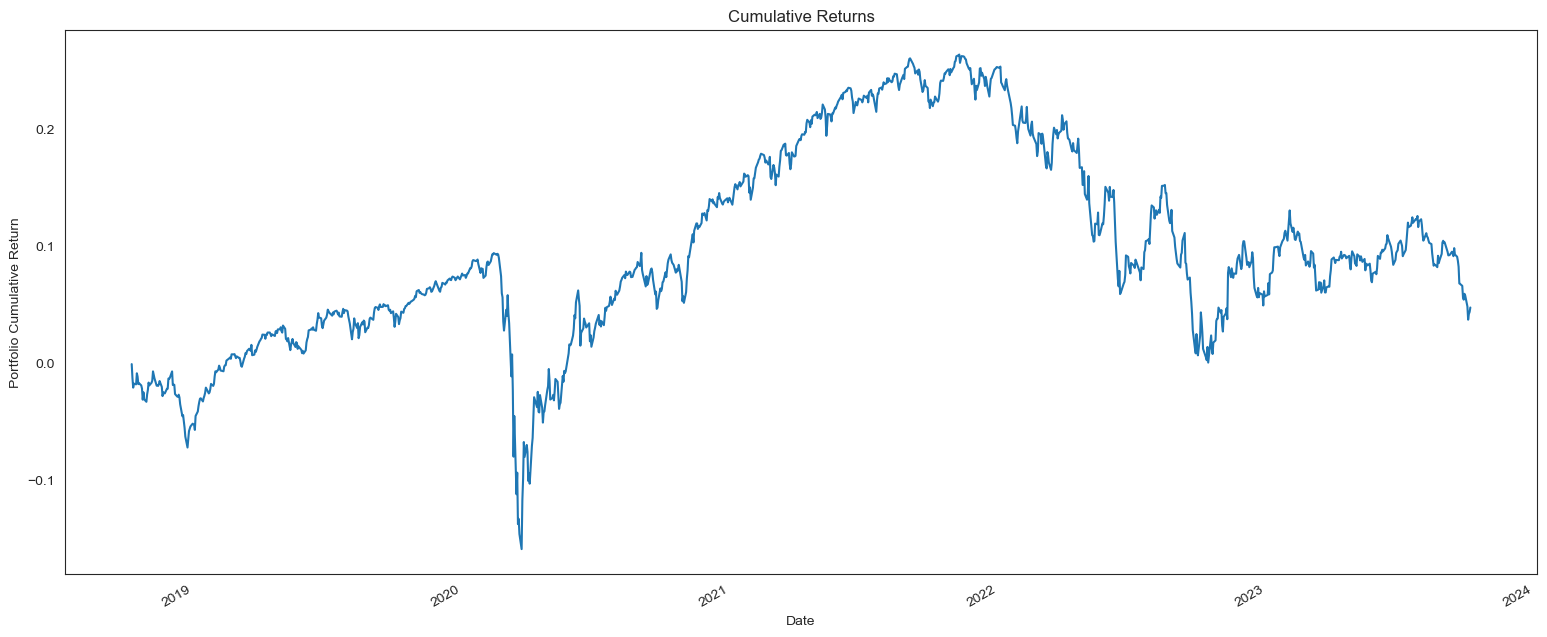

In [199]:
cum_ret_port = ((1 + return_df['Portfolio']).cumprod()-1)
cum_ret_port.plot(label='Cumulative Returns of the Portfolio' ,figsize=(19,8),title='Cumulative Returns')
_=plt.xlabel('Date' )
_=plt.ylabel('Portfolio Cumulative Return' )

In [200]:
port_bench = pd.concat([return_df['Portfolio' ],return_df['Benchmark' ]],axis=1 ).dropna()
port_bench.columns=['Portfolio',' Benchmark' ]
correlation=port_bench.corr()
correlation

,Portfolio,Benchmark
Portfolio,1.000000,0.931899
Benchmark,0.931899,1.000000


In [201]:
return_df['RF Rate']= rf_rate
return_df

,ALTVX,BLUEX,BPLSX,C_A_S_H,DFAR,FREL,FSMD,GARIX,GCHDX,ICBFX,...,VGCAX,VICSX,VIGI,VNQ,VO,VONG,VTEB,Portfolio,Benchmark,RF Rate
Date,,,,,,,,,,,,,,,,,,,,,
2018-10-09,-0.002004,0.001304,0.001426,0.000000,NaN,0.003380,NaN,-0.002701,-0.000796,0.000000,...,NaN,0.000449,-0.003481,0.001387,-0.004246,-0.000193,0.000200,-0.000577,NaN,0.001089
2018-10-10,-0.002008,-0.047238,-0.012340,0.000000,NaN,-0.015579,NaN,-0.012864,-0.019123,-0.001435,...,NaN,0.000449,-0.029648,-0.014854,-0.031168,-0.039845,-0.001796,-0.011822,-0.030125,0.001089
2018-10-11,0.001006,-0.009955,-0.013936,0.000000,NaN,-0.028229,NaN,-0.013717,-0.012998,0.002874,...,NaN,0.001795,-0.004520,-0.028623,-0.020001,-0.016250,0.001199,-0.008377,-0.019590,0.001089
2018-10-12,0.000000,0.027602,0.001462,0.000000,NaN,-0.002641,NaN,0.007649,0.009877,-0.001433,...,NaN,-0.001344,0.010764,-0.002631,0.010172,0.022253,-0.001397,0.003451,0.009148,0.001089
2018-10-15,0.000000,-0.008826,-0.000487,0.000000,NaN,0.005737,NaN,-0.002070,-0.004075,0.000000,...,NaN,0.001346,-0.005324,0.006726,0.001177,-0.007879,-0.000400,-0.000588,0.000139,0.001089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-02,-0.003272,-0.004413,-0.002699,0.000000,-0.017418,-0.018462,-0.012024,0.000000,-0.001894,-0.008489,...,-0.005014,-0.007828,-0.010935,-0.018372,-0.011717,0.008621,-0.008108,-0.008877,-0.009325,0.001089
2023-10-03,-0.003282,-0.006206,-0.005413,0.000000,-0.019291,-0.019704,-0.013299,-0.009245,-0.008539,-0.008562,...,-0.006719,-0.008383,-0.009497,-0.019523,-0.013897,-0.017818,-0.002934,-0.010736,-0.009105,0.001089
2023-10-04,0.000000,0.005650,-0.000680,0.000000,0.011696,0.010964,0.007057,0.005702,0.007655,0.005181,...,0.004510,0.005470,0.007155,0.012222,0.007933,0.013127,0.003363,0.004713,0.003827,0.001089


In [202]:
return_df['excess_b']= return_df['Benchmark'] - return_df['RF Rate' ]

In [203]:
sharpe_ratio=((return_df['Portfolio'].mean() - return_df['RF Rate'].mean()))/return_df['Portfolio' ].std()
round(sharpe_ratio,4)

-0.1407

In [204]:
avg = return_df['Portfolio'].mean() * 100
print(f"Portfolio Return Mean: {avg:.7f}")

Portfolio Return Mean: 0.0063783


In [205]:
std = return_df['Portfolio' ].std()
print(f"Portfolio Return Standard Deviation: {std:.7f}")

Portfolio Return Standard Deviation: 0.0072829
